# Import important libraries

In [ ]:
# pip install scikit-learn

In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

# Load the dataset

In [2]:
#Read the csv file
df = pd.read_csv('Final_nflx_data_2018-2022.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


In [5]:
import seaborn as sns

df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')

In [6]:
df['sentiment_analysis'].value_counts()

sentiment_analysis
neg    1059
pos      71
nue       7
Name: count, dtype: int64

In [7]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300,-0.061196,-88,1438,neg
15,2018-01-24,250.880005,261.709991,249.309998,261.299988,261.299988,17352400,-0.084525,-65,769,neg
16,2018-01-25,263.000000,272.299988,260.230011,269.700012,269.700012,15336400,-0.122744,-102,831,neg
17,2018-01-26,271.489990,274.600006,268.760010,274.600006,274.600006,11021800,-0.118012,-57,483,neg
18,2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,17529700,-0.100690,-73,725,neg
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,neg
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,neg
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,neg
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,neg


In [8]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-23,255.050003,257.709991,248.020004,250.289993,27705300.0,250.289993,-0.061196
2018-01-24,250.880005,261.709991,249.309998,261.299988,17352400.0,261.299988,-0.084525
2018-01-25,263.000000,272.299988,260.230011,269.700012,15336400.0,269.700012,-0.122744
2018-01-26,271.489990,274.600006,268.760010,274.600006,11021800.0,274.600006,-0.118012
2018-01-29,274.200012,286.809998,273.920013,284.589996,17529700.0,284.589996,-0.100690
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


## Data scaling because sigmoid and tanh that are sensitive to magnitude

In [9]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.17239161, 0.16193068, 0.16299819, ..., 0.20085146, 0.15975024,
        0.58996553],
       [0.16449971, 0.16949312, 0.16546293, ..., 0.12256481, 0.18070889,
        0.52005358],
       [0.18743731, 0.18951466, 0.18632733, ..., 0.10732021, 0.19669918,
        0.40552279],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

## Reshape input data into n_samples x timesteps x n_features.

In [10]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1118, 5, 7).
TrainY shape = (1118, 1, 2).


## Model architecture

In [11]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [13]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((894, 5, 6), (894, 5, 7))

In [16]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((804, 5, 6), (804, 5, 7))

In [17]:
# Build models
cnn_lstm_model_without_twitter = build_model((X_train_lstm_without_twitter.shape[1], X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter = build_model((X_train_lstm_twitter.shape[1], X_train_lstm_twitter.shape[2]))

# Train models
history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1)

history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1)

2023-12-14 23:10:03.735921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-14 23:10:03.735996: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-14 23:10:03.736064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter.cs.rutgers.edu): /proc/driver/nvidia/version does not exist
2023-12-14 23:10:03.736735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

## Plotting Training and validation loss

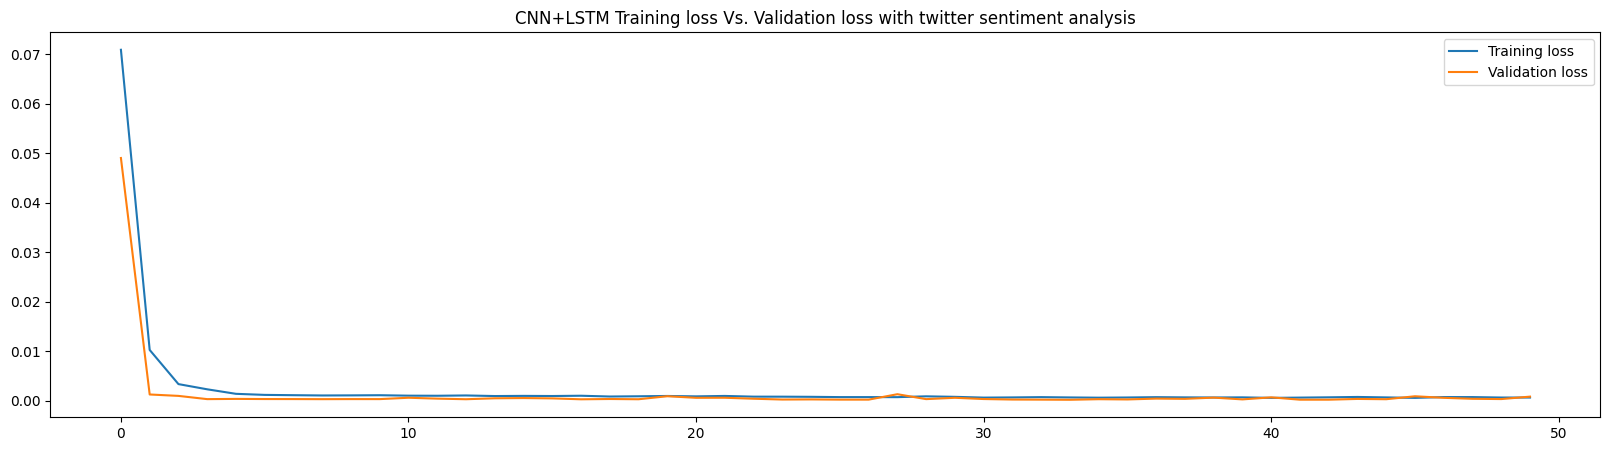

In [18]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('CNN+LSTM Training loss Vs. Validation loss with twitter sentiment analysis')
plt.legend()


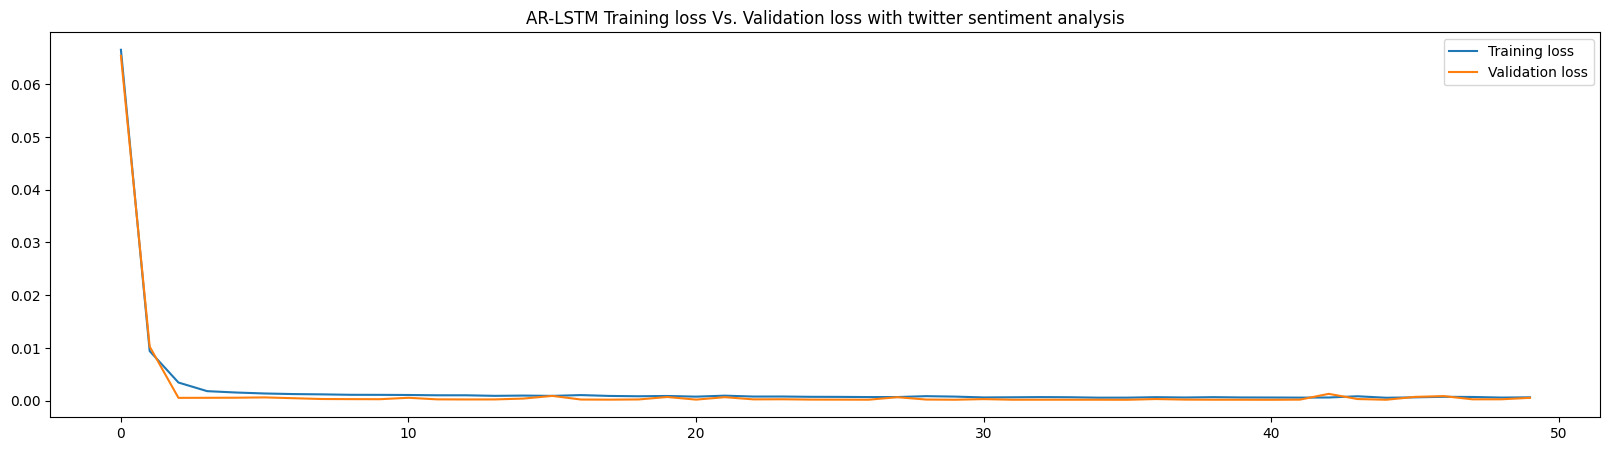

In [19]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('AR-LSTM Training loss Vs. Validation loss with twitter sentiment analysis')
plt.legend()

## Plotting

In [53]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'{type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'{type} prediction of {predicted_feature} feature with twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

# Computing Testing accuracy

In [25]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)



7/7 [==============================] - 0s 5ms/step


In [26]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)



26/26 [==============================] - 0s 4ms/step


#### Testing CNN-LSTM accuracy without twitter

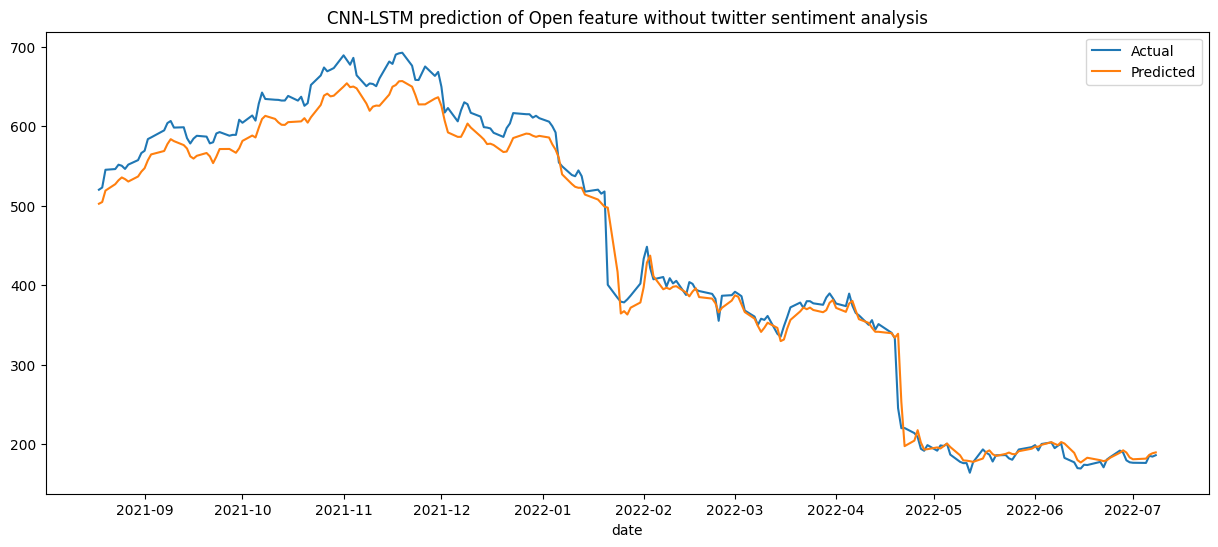

Mean square error for Open =455.3333931393646


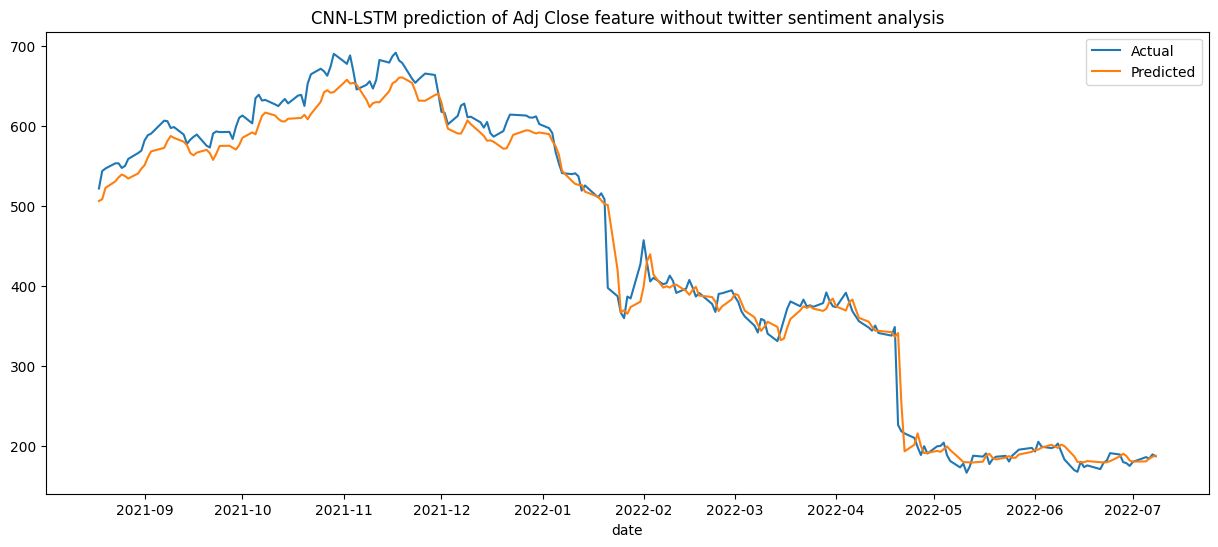

Mean square error for Adj Close =462.6671316528821
Total mean square error 459.0002623961234


In [31]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

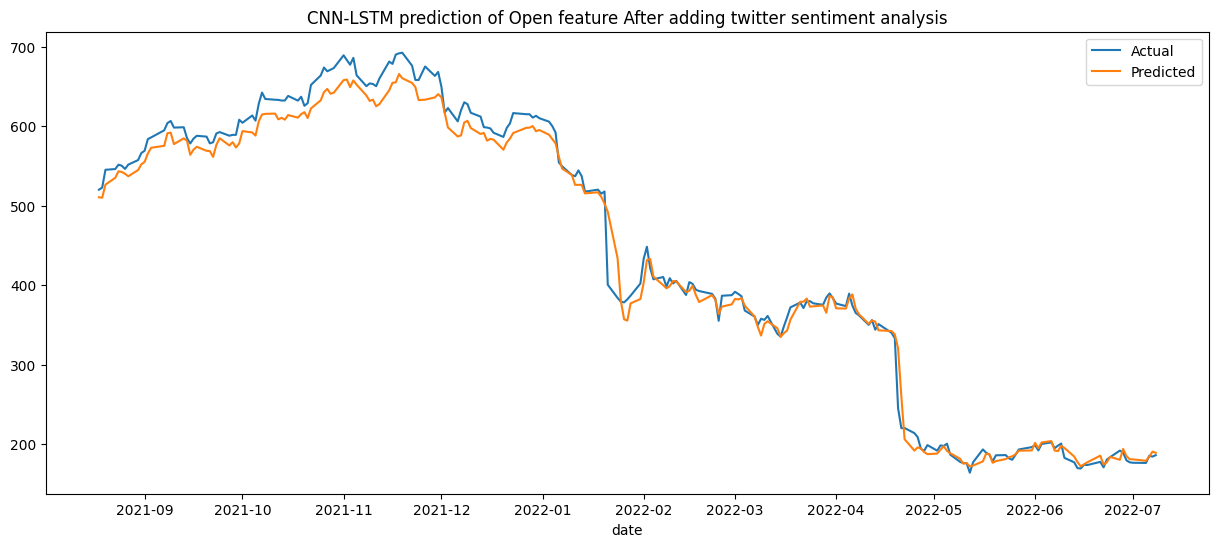

Mean square error for Open =309.50322728961584


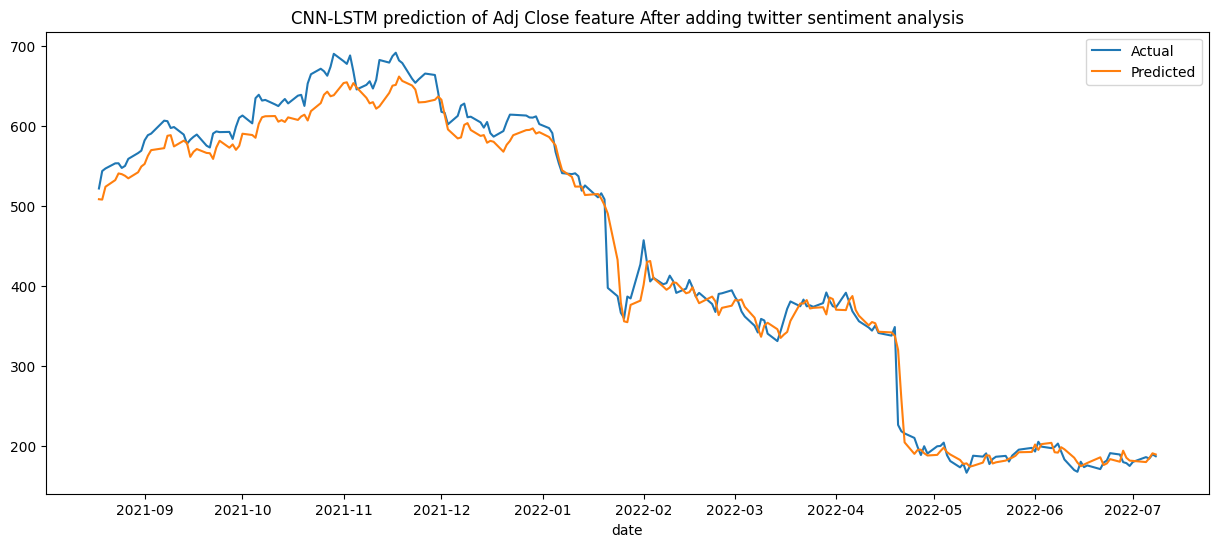

Mean square error for Adj Close =458.83461747265375
Total mean square error 384.1689223811347


In [54]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

# AR LSTM

In [35]:
df_arlstm=df_for_training.copy()
# df_arlstm['Volume']=df['Volume']
n_past_for_arlstma=1
adj_close_feature=df_arlstm['Adj Close']
open_feature=df_arlstm['Open']
df_arlstm['Adj Close']=df_arlstm['Adj Close'].shift(-n_past_for_arlstm)
df_arlstm['Open']=df_arlstm['Open'].shift(-n_past_for_arlstm)
df_arlstm.dropna(inplace=True)
df_arlstm['Adj Close_feature']=adj_close_feature.iloc[:-1]
df_arlstm['open_feature_feature']=open_feature.iloc[:-1]
# df_arlstm=df_arlstm.reindex(columns=['open_lag','High', 'Low', 'Close', 'adj_close_lag','P_mean','Adj Close','Open',])
X_arlstm=df_arlstm.drop(['Adj Close','Open'],axis=1)
y_arlstm=df_arlstm[['Open','Adj Close']]
X_train_arlstm_twitter, X_test_arlstm_twitter, y_train_arlstm, y_test_arlstm=train_test_split(X_arlstm, y_arlstm, test_size=0.2, shuffle=False)

X_train_arlstm_without_twitter, X_test_arlstm_without_twitter= X_train_arlstm_twitter.drop('P_mean', axis=1), X_test_arlstm_twitter.drop('P_mean', axis=1)
X_train_arlstm_without_twitter


,High,Low,Close,Volume,Adj Close_feature,open_feature_feature
date,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,250.289993,255.050003
2018-01-24,261.709991,249.309998,261.299988,17352400.0,261.299988,250.880005
2018-01-25,272.299988,260.230011,269.700012,15336400.0,269.700012,263.000000
2018-01-26,274.600006,268.760010,274.600006,11021800.0,274.600006,271.489990
2018-01-29,286.809998,273.920013,284.589996,17529700.0,284.589996,274.200012
...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,519.969971,521.150024
2021-08-10,520.789978,512.969971,515.840027,1960500.0,515.840027,520.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,512.400024,517.000000


In [36]:
X_train_arlstm_twitter

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,-0.061196,250.289993,255.050003
2018-01-24,261.709991,249.309998,261.299988,17352400.0,-0.084525,261.299988,250.880005
2018-01-25,272.299988,260.230011,269.700012,15336400.0,-0.122744,269.700012,263.000000
2018-01-26,274.600006,268.760010,274.600006,11021800.0,-0.118012,274.600006,271.489990
2018-01-29,286.809998,273.920013,284.589996,17529700.0,-0.100690,284.589996,274.200012
...,...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,-0.051282,519.969971,521.150024
2021-08-10,520.789978,512.969971,515.840027,1960500.0,-0.085427,515.840027,520.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,-0.058824,512.400024,517.000000


In [ ]:
from pmdarlstm import auto_arlstm
arlstm_model_for_open_without_twitter = auto_arlstm(y_train_arlstm['Open'], exogenous=X_train_arlstm_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arlstm_model_for_open_twitter = auto_arlstm(y_train_arlstm['Open'], exogenous=X_train_arlstm_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arlstm_model_for_open_without_twitter.summary()
arlstm_model_for_open_twitter.summary()

In [ ]:
from pmdarlstm import auto_arlstm
arlstm_model_for_Adj_Close_without_twitter = auto_arlstm(y_train_arlstm['Adj Close'], exogenous=X_train_arlstm_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arlstm_model_for_Adj_Close_twitter = auto_arlstm(y_train_arlstm['Adj Close'], exogenous=X_train_arlstm_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arlstm_model_for_Adj_Close_without_twitter.summary()
arlstm_model_for_Adj_Close_twitter.summary()

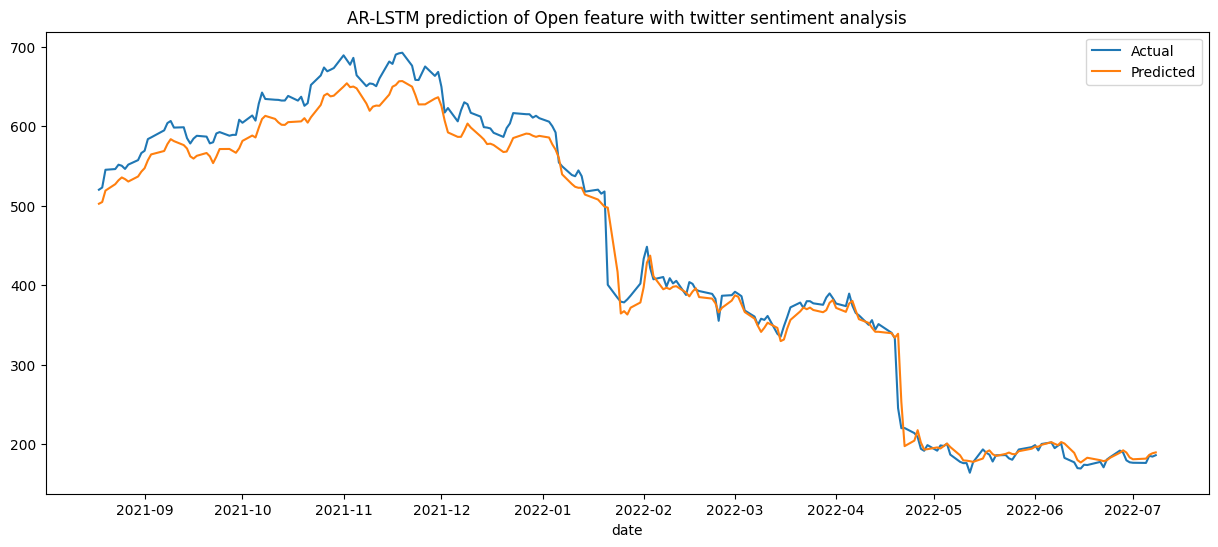

Mean square error for Open =455.3333931393646


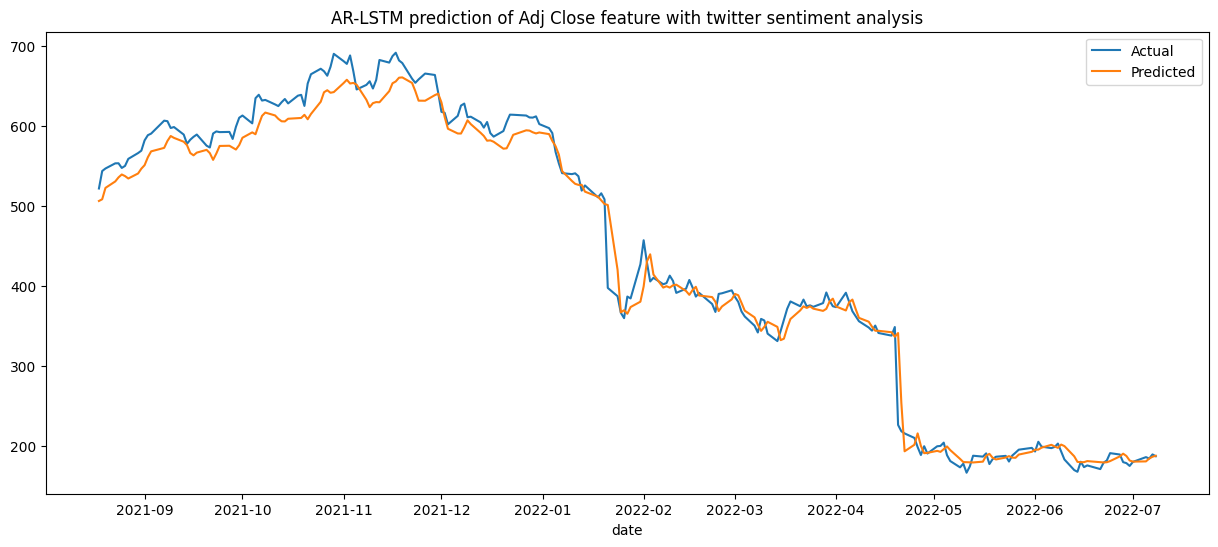

Mean square error for Adj Close =462.6671316528821
Total mean square error 459.0002623961234


In [50]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

####  Training accuracy without twitter

## arlstm model to predict open prices

In [ ]:
from pmdarlstm import auto_arlstm
arlstm_model_for_open_without_twitter = auto_arlstm(y_train_arlstm['Open'], exogenous=X_train_arlstm_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arlstm_model_for_open_twitter = auto_arlstm(y_train_arlstm['Open'], exogenous=X_train_arlstm_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arlstm_model_for_open_without_twitter.summary()
arlstm_model_for_open_twitter.summary()

## Computing training accuracy for open prices

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arlstm_model_for_open_without_twitter.predict(n_periods=len(X_train_arlstm_without_twitter), exogenous=X_train_arlstm_without_twitter)
train_prediction_twitter= arlstm_model_for_open_twitter.predict(n_periods=len(X_train_arlstm_twitter), exogenous=X_train_arlstm_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arlstm['Open'].index, y=y_train_arlstm['Open'], label='Actual')
sns.lineplot(x=y_train_arlstm['Open'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('arlstm training Accuracy for Open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arlstm['Open'])
print(f'Training mean square error for open feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arlstm['Open'].index, y=y_train_arlstm['Open'], label='Actual')
sns.lineplot(x=y_train_arlstm['Open'].index, y=train_prediction_twitter, label='Prediction')
plt.title('arlstm training Accuracy for Open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arlstm['Open'])
print(f'Training mean square error for open feature with twitter {e}')


## Computing testing accuracy for open prices

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arlstm_model_for_open_without_twitter.predict(n_periods=len(X_test_arlstm_without_twitter), exogenous=X_test_arlstm_without_twitter)
test_prediction_twitter= arlstm_model_for_open_twitter.predict(n_periods=len(X_test_arlstm_twitter), exogenous=X_test_arlstm_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arlstm['Open'].index, y=y_test_arlstm['Open'], label='Actual')
sns.lineplot(x=y_test_arlstm['Open'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('arlstm testing Accuracy for open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arlstm['Open'])
print(f'Testing mean square error for open feature without twitter sentiment analysis {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arlstm['Open'].index, y=y_test_arlstm['Open'], label='Actual')
sns.lineplot(x=y_test_arlstm['Open'].index, y=test_prediction_twitter, label='Prediction')
plt.title('arlstm testing Accuracy for open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arlstm['Open'])
print(f'Testing mean square error for open feature with twitter sentiment analysis {e}')


## arlstm model for Adjusted Close prices

In [ ]:
from pmdarlstm import auto_arlstm
arlstm_model_for_Adj_Close_without_twitter = auto_arlstm(y_train_arlstm['Adj Close'], exogenous=X_train_arlstm_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arlstm_model_for_Adj_Close_twitter = auto_arlstm(y_train_arlstm['Adj Close'], exogenous=X_train_arlstm_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arlstm_model_for_Adj_Close_without_twitter.summary()
arlstm_model_for_Adj_Close_twitter.summary()

## Computing training accuracy for Adjusted Close prices

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arlstm_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_train_arlstm_without_twitter), exogenous=X_train_arlstm_without_twitter)
train_prediction_twitter= arlstm_model_for_Adj_Close_twitter.predict(n_periods=len(X_train_arlstm_twitter), exogenous=X_train_arlstm_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arlstm['Adj Close'].index, y=y_train_arlstm['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arlstm['Adj Close'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('arlstm training Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arlstm['Adj Close'])
print(f'Training mean absolute error for Adj Close feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arlstm['Adj Close'].index, y=y_train_arlstm['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arlstm['Adj Close'].index, y=train_prediction_twitter, label='Prediction')
plt.title('arlstm training Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arlstm['Adj Close'])
print(f'Training mean absolute error for Adj Close feature with twitter {e}')


## Computing testing accuracy for Adjusted close prices

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arlstm_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_test_arlstm_without_twitter), exogenous=X_test_arlstm_without_twitter)
test_prediction_twitter= arlstm_model_for_Adj_Close_twitter.predict(n_periods=len(X_test_arlstm_twitter), exogenous=X_test_arlstm_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arlstm['Adj Close'].index, y=y_test_arlstm['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arlstm['Adj Close'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('arlstm testing Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arlstm['Adj Close'])
print(f'Testing absolute mean square error for Adj Close feature without twitter sentiment analysis {e}')
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arlstm['Adj Close'].index, y=y_test_arlstm['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arlstm['Adj Close'].index, y=test_prediction_twitter, label='Prediction')
plt.title('arlstm testing Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arlstm['Adj Close'])
print(f'Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis {e}')


In [ ]:
test_prediction_twitter

# Forcasting for upcoming data

In [44]:
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past_dates = 5
n_days_for_prediction = 5 #let us predict past 15 days

predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-05 00:00:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-07 00:00:00'), Timestamp('2022-07-08 00:00:00')]


In [45]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

## Make forcasting using LSTM

In [46]:
x_forcast=df_for_training.iloc[-n_past-1:-1,:]
x_forcast=scaler.transform(x_forcast).reshape(1,n_past,len(features))
prediction = cnn_lstm_model_twitter.predict(x_forcast) #shape = (n, 1) where n is the n_days_for_prediction
prediction=prediction.reshape(prediction.shape[0],prediction.shape[2])
#Perform inverse transformation to rescale back to original range
prediction=scaler_for_inference.inverse_transform(prediction)

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {prediction[0][0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {prediction[0][1]}')

1/1 [==============================] - 0s 21ms/step
Date = 2022-07-07, Prediction open 189.04718017578125
Date = 2022-07-07, Prediction Adjusted close 189.20326232910156


### Actual forcasting in 2022-07-07 are  open 184.27     adjusted close 189.27

## Forcasting for upcoming data using arlstm

In [47]:
x_forcast=X_arlstm[X_arlstm.index =='2022-07-07']
x_forcast

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2022-07-07,190.210007,183.5,189.270004,6334500.0,-0.055427,189.270004,184.270004


In [ ]:
x_forcast=X_arlstm[X_arlstm.index =='2022-07-07']
open_prediction = arlstm_model_for_open_twitter.predict(n_periods=len(x_forcast), exogenous=x_forcast)
adj_close_prediction = arlstm_model_for_Adj_Close_twitter.predict(n_periods=len(x_forcast),exogenous=x_forcast)#shape = (n, 1) where n is the n_days_for_prediction
# open_prediction=float(open_prediction)
# adj_close_prediction=float(adj_close_prediction)
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {open_prediction[0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {adj_close_prediction[0]}')

### Actual for 2022-07-07  forcasting  open 184.27     adjusted close 189.27